In [1]:
# Importing Qiskit libraries
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [4]:
def peg(qc : QuantumCircuit, qubit : int) -> None:
    """
    Implements a single non-biased peg in the Quantum Galton Board.
    The peg allows the ball to deflect left or right with equal probability.
    Args:
        qc (QuantumCircuit): The quantum circuit to which the peg operation will be added.
        qubit (int): The index of the qubit representing the peg.
    """
    qc.cswap(0,qubit,qubit-1)
    qc.cx(qubit,0)
    qc.cswap(0,qubit,qubit+1)

In [ ]:
def level(qc : QuantumCircuit,  l : int, n : int) -> None:
    """
    Implements a row of non-biased pegs in the Quantum Galton Board.
    Args:
        qc (QuantumCircuit): The quantum circuit to which the row of pegs will be added.
        l (int): The number of pegs in the row.
        n (int): The total number of levels in the Quantum Galton Board.
    """
    peg(qc, n+1-l)
    for i in range(n+3-l, n+l+2, 2):
        qc.cx(i-1, 0) # Put the control qubit back in superposition
        peg(qc, i)

# Standard QGB Circuit

The following circuit implements a Quantum Galton Board (QGB) using Qiskit. The QGB simulates the behavior of a Standard Galton board, where each peg has 50% chance of deflecting a ball to the left or right. The circuit is designed to handle a specified number $n$ of levels. 

In [9]:
def standard_qgb(n : int) -> QuantumCircuit:
    """
    Constructs a Quantum Galton Board (QGB) circuit with `n` levels.
    Args:
        n (int): The number of levels in the Quantum Galton Board.
    Returns:
        QuantumCircuit: The quantum circuit representing the Quantum Galton Board.
    """
    qc = QuantumCircuit(2*n+2, n+1)
    qc.x(n+1)
    for l in range(n):
        qc.reset(0)
        qc.h(0)
        level(qc, l, n)
    qc.barrier()
    for p in range(n+1):
        qc.measure(2*p+1, p)
    return qc

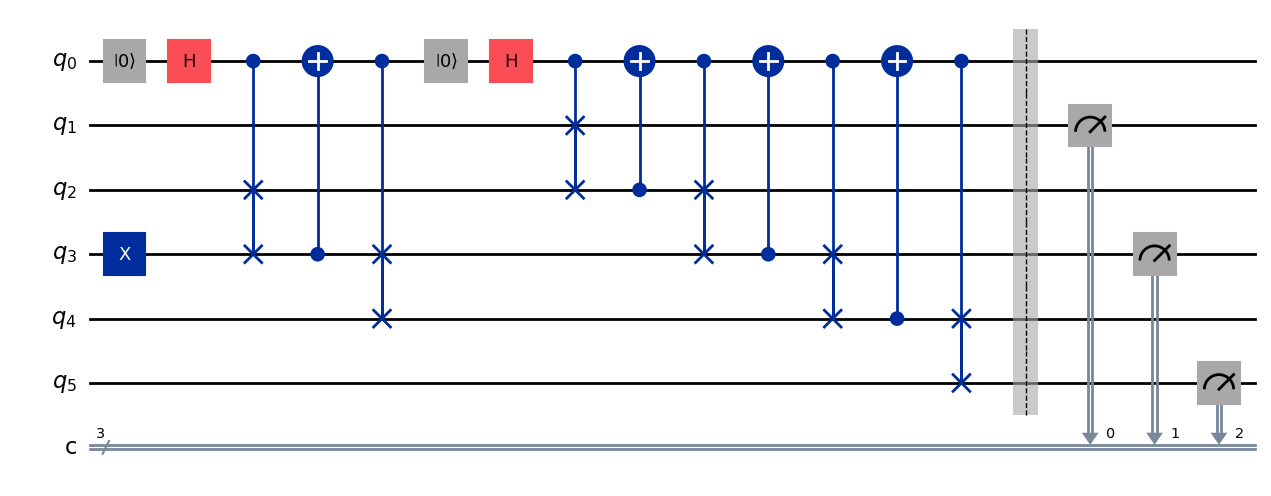

In [10]:
standard_qgb(2).draw(output="mpl")

## Testing on a 6-levels Standard QGB

In [11]:
standard_circuit = standard_qgb(6)

### Simulation
You can notice that we obtain a gaussian distribution

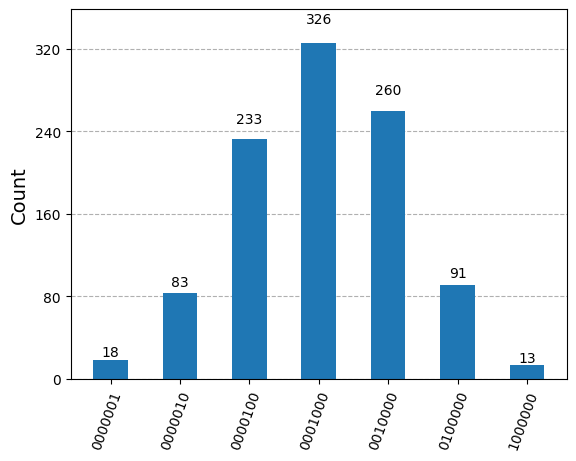

In [12]:
simulator = AerSimulator()
compiled_circuit = transpile(standard_circuit, simulator)
result = simulator.run(compiled_circuit, shots=1024).result()
counts = result.get_counts()
plot_histogram(counts)

# Exponential Distribution QGB

In order to obtain an exponential distribution, we change the bias of the pegs such that the rightmost peg of each row has equal probability of sending the ball to the right or to the left, whereas the other pegs in the row always send the ball to the left. It follows that in the last rows, the two rightmost columns have equal probability of receiving the ball, then moving leftward, the probability of each column doubles compared to the one on its right.
The proof is simple induction.

In [13]:
def expo_qgb(n : int) -> QuantumCircuit:
    """
    Constructs a Quantum Galton Board (QGB) circuit with `n` levels using an exponential approach.
    Args:
        n (int): The number of levels in the Quantum Galton Board.
    Returns:
        QuantumCircuit: The quantum circuit representing the Quantum Galton Board.
    """
    qc = QuantumCircuit(2*n+2, n+1)
    qc.x(n+1)
    for l in range(n):
        qc.reset(0)
        qc.h(0)
        peg(qc, n+1-l)
        for i in range(n+3-l, n+l+2, 2):
            qc.swap(i,i+1)
    qc.barrier()
    for p in range(n+1):
        qc.measure(2*p+1, p)
    return qc

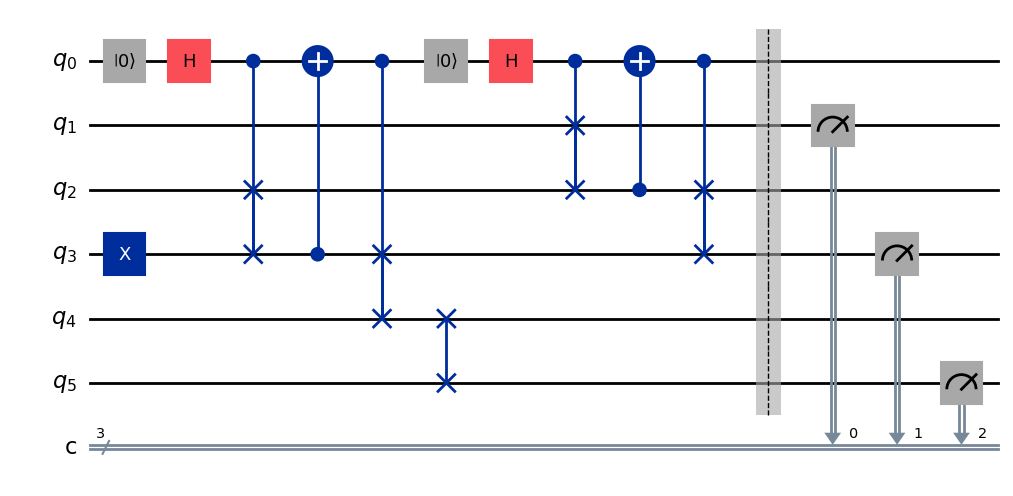

In [16]:
expo_qgb(2).draw(output='mpl')

In [14]:
expo_circuit = expo_qgb(6)

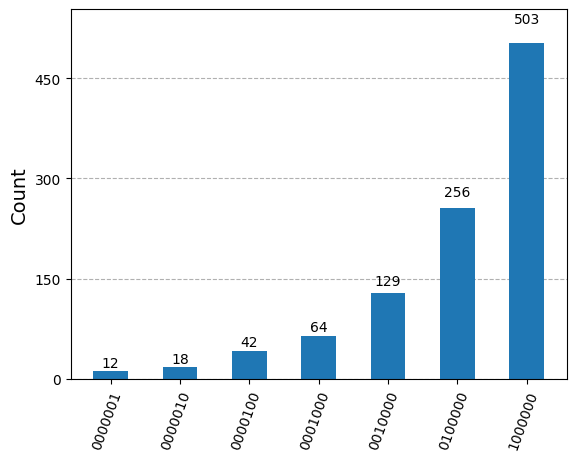

In [15]:
simulator = AerSimulator()
compiled_circuit = transpile(expo_circuit, simulator)
result = simulator.run(compiled_circuit, shots=1024).result()
counts = result.get_counts()
plot_histogram(counts)


# Simulating a Hadamard quantum walk

We are willing here to implement a 1D quantum walk as described in https://www.math.uwaterloo.ca/~anayak/papers/AmbainisBNVW01.pdf.

One can observe that the process for the QGB is very similar to a Hadamard Quantum Walk, and that only a few changes to our standard circuit are needed to turn it into a Hadamard quantum walk. It sufficies to make sure the control qubit is restored after applying every peg (including the last one of the levels), and not resetting the control qubit.

In [17]:
def hadamard_walk_qgb(n : int) -> QuantumCircuit:
    """
    Constructs a Quantum Galton Board (QGB) circuit using Hadamard walk with `n` levels.
    Args:
        n (int): The number of levels in the Quantum Galton Board.
    Returns:
        QuantumCircuit: The quantum circuit representing the Quantum Galton Board.
    """
    qc = QuantumCircuit(2*n+2, n+1)
    qc.x(n+1)
    for l in range(n):
        qc.h(0)
        level(qc, l, n)
        qc.cx(n+l+2, 0)
    qc.barrier()
    for p in range(n+1):
        qc.measure(2*p+1, p)
    return qc

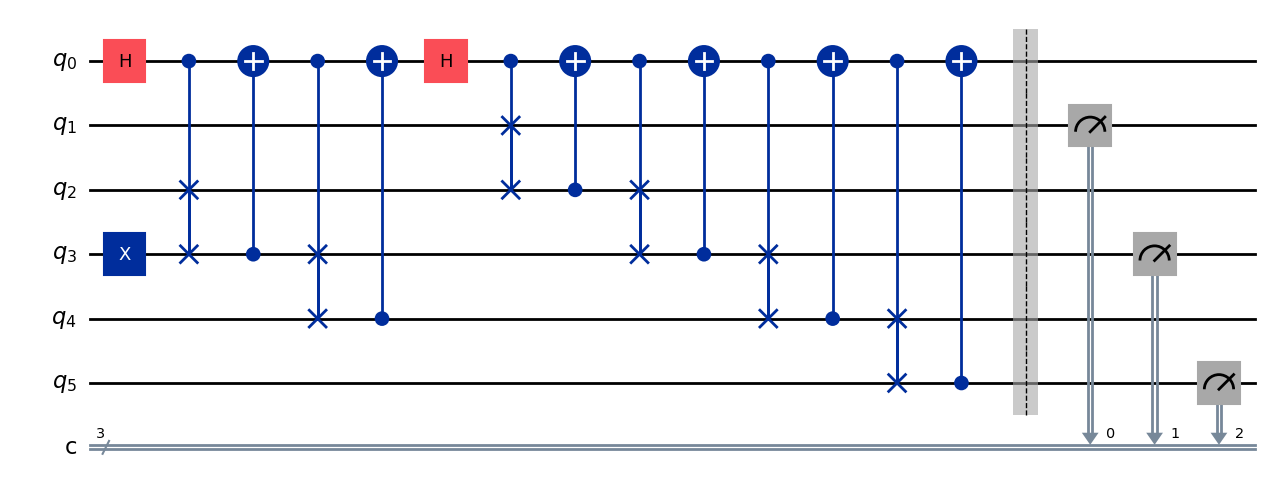

In [18]:
hadamard_walk_qgb(2).draw(output='mpl')

In [51]:
hadamard_circuit = hadamard_walk_qgb(8)

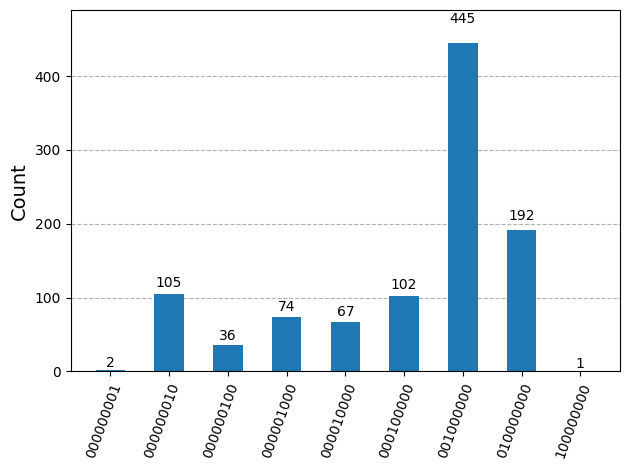

In [52]:
simulator = AerSimulator()
compiled_circuit = transpile(hadamard_circuit, simulator)
result = simulator.run(compiled_circuit, shots=1024).result()
counts = result.get_counts()
plot_histogram(counts)